<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertAndInferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the first and second steps in the split workflow on Terra

DICOM files are downloaded and converted to NIFTI files. NIFTI files are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [ ]:
# %%capture
# #Installing lz4 for compression/decompression; dcm2niix and plastimatch for conversion; 
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 xvfb dcm2niix pigz plastimatch ffmpeg

In [ ]:
# %%capture
# #Installing Totalsegmentator for Inference
# #pyradiomics required for extracting radiomics features 
# #nvidia-ml-py3 for capturing gpu utilization
# !pip install TotalSegmentator pyradiomics nvidia-ml-py3

In [ ]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd

###Importing Packages

In [ ]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil
import glob
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
import nvidia_smi
import subprocess

In [ ]:
curr_dir   = Path().absolute()

os.environ['TZ'] = 'US/Eastern'
time.tzset()
current_time = time.strftime('%a %b %d %H:%M:%S %Y', time.localtime())
print(current_time)
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Wed Apr 12 10:33:50 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Parameters for papermill

In [ ]:
converterType='dcm2niix'
csvFilePath=''

###**Local testing**

In [ ]:
# !wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
# csvFilePath =glob.glob('*.csv')[0]

--2023-04-12 10:33:50--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv.2’

batch_1.csv.2       100%[===================>] 136.58K  --.-KB/s    in 0.01s   

2023-04-12 10:33:50 (10.2 MB/s) - ‘batch_1.csv.2’ saved [139861/139861]



###Reading CSV File containing s5cmd Urls

In [ ]:
#get the path of the zip file containing csv file in the current working directory3
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.


#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path= '/home/vamsi/Downloads/result.csv'
#csvFilePath=csvFilePath.replace("gs://", "/cromwell_root/")

start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
#cohort_df= pd.read_csv('/content/drive/MyDrive/idc/bq-results-20230315-160529-1678896367937.csv')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.06679630279541016  seconds


In [ ]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
#SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
#SeriesInstanceUIDs=[ '1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138',
# '1.2.840.113654.2.55.99651797089556982668213819691341139949'  
# ]

###Defining Functions

In [ ]:
#Creating Directories for conversion
if converterType.lower()=='dcm2niix':
  try:
    shutil.rmtree('dcm2niix')
  except OSError:
    pass
  os.mkdir('dcm2niix')
else:
  try:
    shutil.rmtree('plastimatch')
  except OSError:
    pass
  os.mkdir('plastimatch')

In [ ]:
#create directory for TotalSegmentator Output files

try:
  shutil.rmtree('Inference')
  shutil.rmtree('metadata')
except OSError:
  pass
os.mkdir('Inference')
os.mkdir('metadata')

In [ ]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.
  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  #!cat 

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [ ]:
def convert_dicom_to_nifti(series_id):
  
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [ ]:
def check_dicom_conversion_errors(series_id_folder_path):
    nifti_files = os.listdir(series_id_folder_path)
    if len(nifti_files) > 1:
        with open('error_file.txt', 'a') as f:
            f.write(f"Error: More than one file in {series_id_folder_path}\n")
        return True
    else:
        return False

In [ ]:
def check_total_segmentator_errors(series_id):
    try:
        # Check if the output files from TotalSegmentator exist
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/segmentations.nii")
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/statistics_radiomics.json")
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/preview_total.png")
    except AssertionError:
        # If any of the output files do not exist, log an error
        with open('totalsegmentator_errors.txt', 'a') as f:
            f.write(f"Error: TotalSegmentator failed for series {series_id}\n")
        return True
    return False

In [ ]:
def inferenceTotalSegmentator(series_id):

      start_time = time.time()
      download_dicom_data(series_id)
      dicom_download_time = time.time() - start_time      

      start_time = time.time()
      convert_dicom_to_nifti(series_id)
      dicom_conversion_time = time.time() - start_time     

      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'metadata/{series_id}')
        os.remove('segmentations.nii.gz')
        os.remove('statistics_radiomics.json')
        os.remove('preview_total.png')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')
      os.mkdir(f'metadata/{series_id}')

      print("Processing series: "+series_id)  


      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
      
      if not check_dicom_conversion_errors(series_id_folder_path):

        start_time = time.time()
        #!TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --fast --preview  --radiomics 
        result=subprocess.run(['TotalSegmentator', '-i', nifti_filename_path, '-o', 'segmentations', '--ml', '--preview', '--radiomics'],stdout=subprocess.PIPE, stderr=subprocess.PIPE,  universal_newlines=True)
        print(result.stdout)
        total_segmentator_time = time.time() - start_time

        try:
          subprocess.run(["mv", f"{curr_dir}/preview_total.png", f"{curr_dir}/segmentations.nii", f"{curr_dir}/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
          print("Files moved successfully using the first command")
        except subprocess.CalledProcessError:
          try:
            subprocess.run(["mv", "segmentations/preview_total.png", "segmentations/segmentations.nii", "segmentations/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
          except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")

        check_total_segmentator_errors(series_id)
        
        # !mv {curr_dir}/preview_total.png {curr_dir}/segmentations.nii {curr_dir}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/
        # !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii
        # !mv {curr_dir}/Inference/{series_id}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json      
        # !mv {curr_dir}/Inference/{series_id}/preview_total.png {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png

        start_time = time.time()  
        !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
        !tar cvf - {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png | lz4 > {curr_dir}/metadata/{series_id}/{series_id}_metadata.tar.lz4
        archiving_time = time.time() - start_time

      else: 
        total_segmentator_time=0
        archiving_time=0

      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 

      log['dicom_download_time']=dicom_download_time
      log['dicom_conversion_time']=dicom_conversion_time            
      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png
      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [ ]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

###Total Segmentator

Copying files from IDC buckets..
Done in 0.625825 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 181 DICOM file(s)
Convert 181 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2 (512x512x181x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2.nii"
Conversion required 5.223509 seconds (0.281781 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 3.07s
Predict

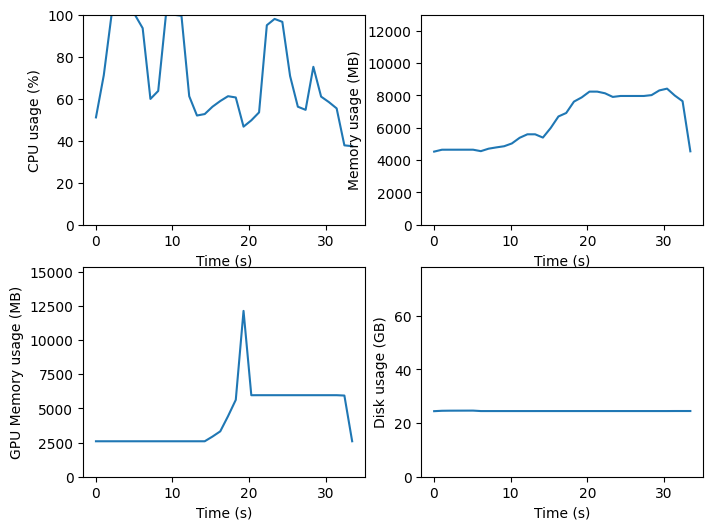

Copying files from IDC buckets..
Done in 0.717849 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 115 DICOM file(s)
Convert 115 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2 (512x512x115x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2.nii"
Conversion required 4.222584 seconds (0.228237 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 1.97s
Predicting.

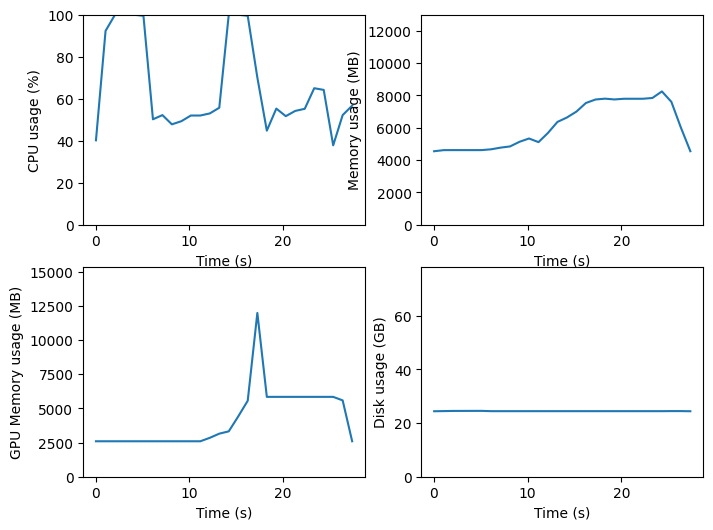

Copying files from IDC buckets..
Done in 0.827239 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 135 DICOM file(s)
Convert 135 DICOM as //content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2 (512x512x135x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 3.307351 seconds (0.241784 for core code).
Processing series: 1.2.840.113654.2.55.100875189782210690344207306235124901243

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 2.78s
Predicting...

If you use this tool plea

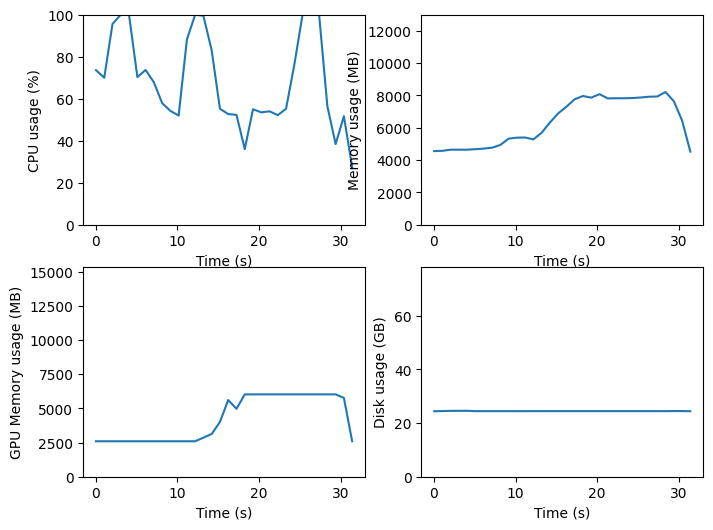

Copying files from IDC buckets..
Done in 0.72634 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 191 DICOM file(s)
Convert 191 DICOM as //content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x191x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 5.538004 seconds (0.337215 for core code).
Processing series: 1.2.840.113654.2.55.113040386178547843571271236478024341696

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 3.16s
Predicting...

If you use this tool p

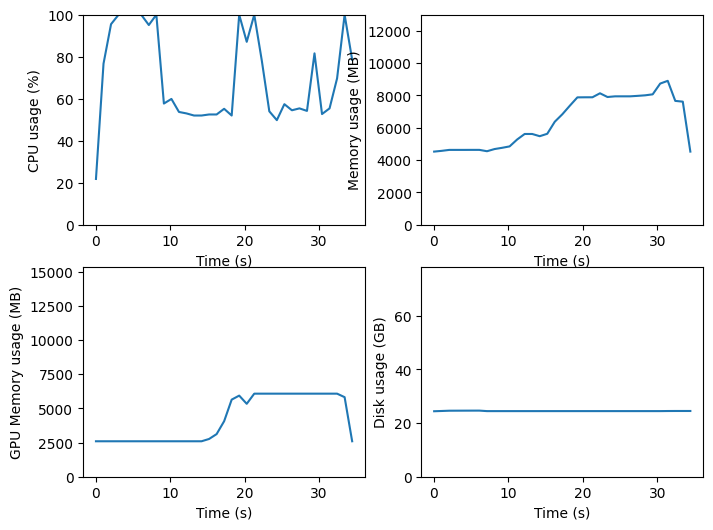

Copying files from IDC buckets..
Done in 0.52041 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.142419057730651121165090739113900499978/1.2.840.113654.2.55.142419057730651121165090739113900499978_2_OPA_GE_LSQX_BONE_360_2.5_120_72_0.1_1.5_20010102000000_3 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.142419057730651121165090739113900499978/1.2.840.113654.2.55.142419057730651121165090739113900499978_2_OPA_GE_LSQX_BONE_360_2.5_120_72_0.1_1.5_20010102000000_3.nii"
Conversion required 3.022696 seconds (0.242972 for core code).
Processing series: 1.2.840.113654.2.55.142419057730651121165090739113900499978

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 2.93s
Predicting...

If you use this tool please ci

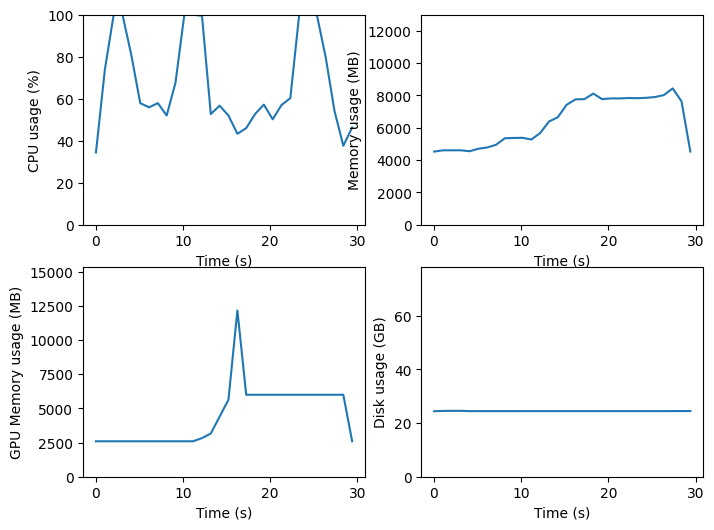

Copying files from IDC buckets..
Done in 0.523209 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 122 DICOM file(s)
Convert 122 DICOM as //content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2 (512x512x122x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 2.919780 seconds (0.211078 for core code).
Processing series: 1.2.840.113654.2.55.14382674871619950799472325766084940706

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 2.09s
Predicting...

If you use this tool please ci

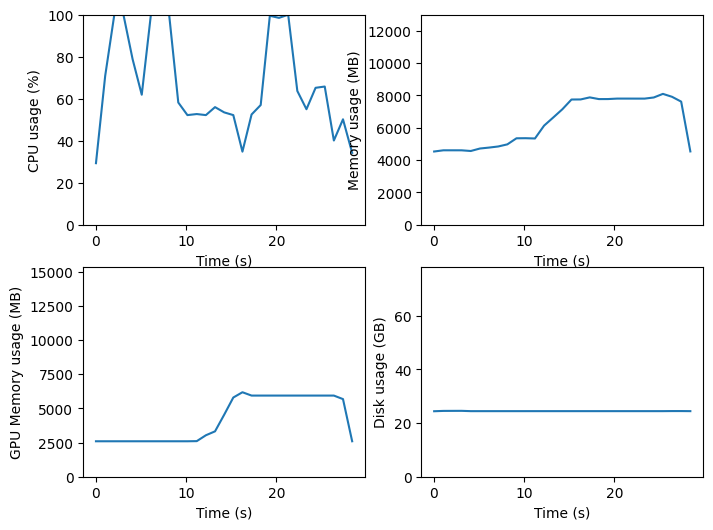

Copying files from IDC buckets..
Done in 0.521431 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 139 DICOM file(s)
Convert 139 DICOM as //content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2 (512x512x139x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2.nii"
Conversion required 5.165187 seconds (0.246239 for core code).
Processing series: 1.2.840.113654.2.55.146601594654322994982630019583270053397

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 2.46s
Predicting...

If you use this tool plea

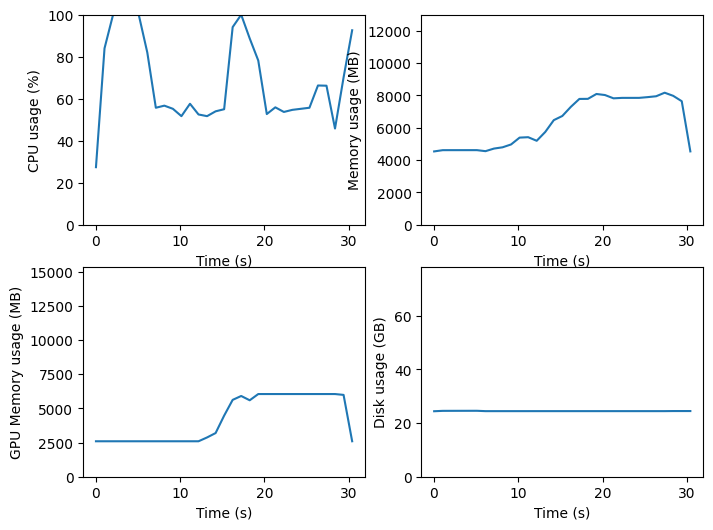

Copying files from IDC buckets..
Done in 0.625334 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 112 DICOM file(s)
Convert 112 DICOM as //content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x112x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 2.796711 seconds (0.197095 for core code).
Processing series: 1.2.840.113654.2.55.154809705591242159075253605419469935510

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 1.83s
Predicting...

If you use this tool 

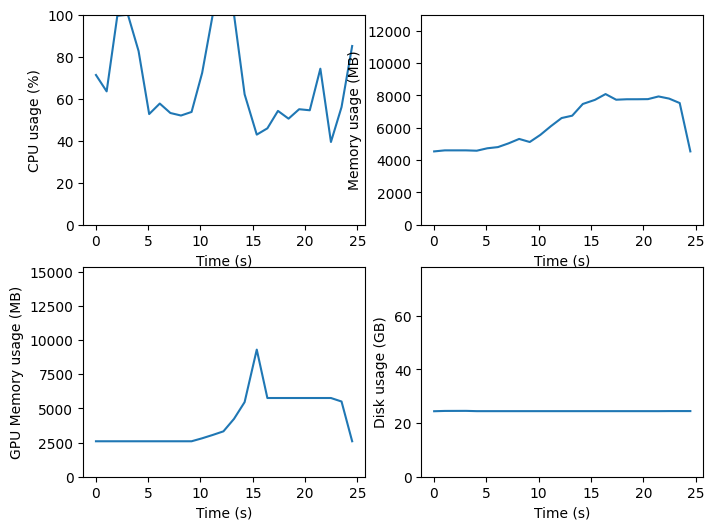

Copying files from IDC buckets..
Done in 0.617565 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 158 DICOM file(s)
Convert 158 DICOM as //content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2 (512x512x158x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2.nii"
Conversion required 3.856044 seconds (0.298944 for core code).
Processing series: 1.2.840.113654.2.55.185309182591805634517860395342326800332

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 3.21s
Predicting...

If you use this tool plea

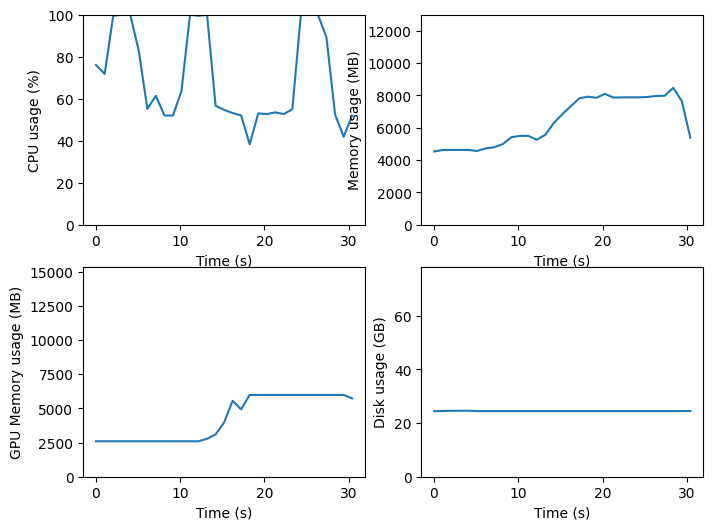

Copying files from IDC buckets..
Done in 0.520812 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 130 DICOM file(s)
Convert 130 DICOM as //content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3 (512x512x130x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3.nii"
Conversion required 3.114682 seconds (0.228303 for core code).
Processing series: 1.2.840.113654.2.55.216614002338888733987350522981366678482

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 2.20s
Predicting...

If you use this tool please c

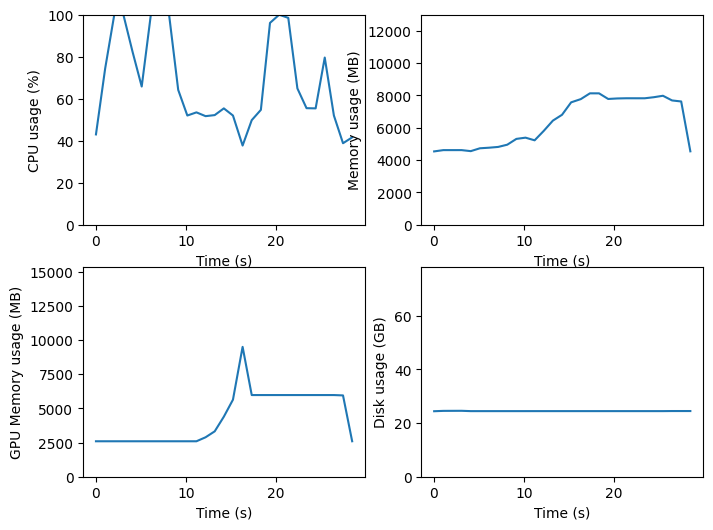

Copying files from IDC buckets..
Done in 0.526185 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2.nii"
Conversion required 4.347803 seconds (0.233927 for core code).
Processing series: 1.2.840.113654.2.55.22770087029972268579113866309746562015

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 2.49s
Predicting...

If you use this tool pleas

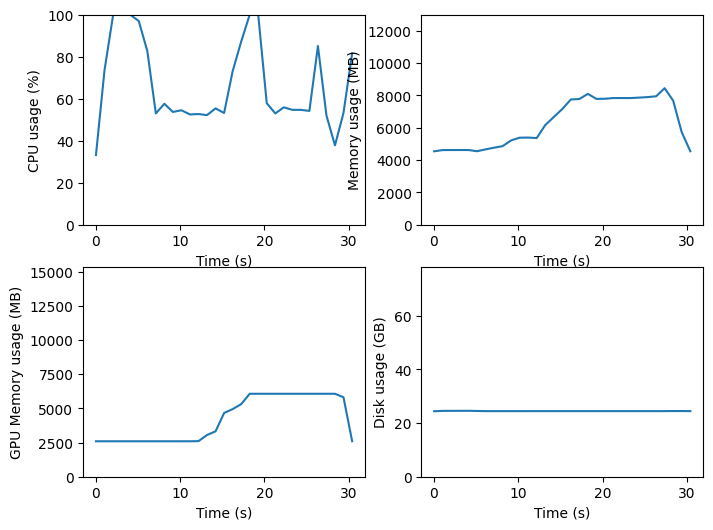

Copying files from IDC buckets..
Done in 0.62167 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 180 DICOM file(s)
Convert 180 DICOM as //content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2 (512x512x180x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2.nii"
Conversion required 4.401946 seconds (0.318569 for core code).
Processing series: 1.2.840.113654.2.55.243990451406006403331425809632881193215

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 3.82s
Predicting...

If you use this tool p

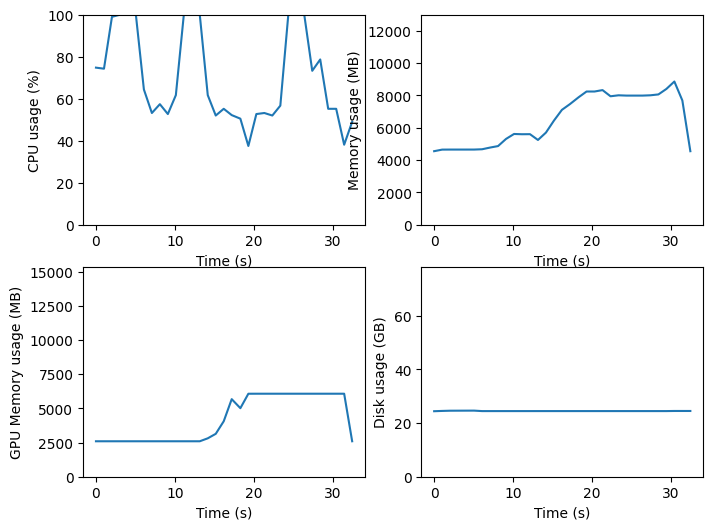

In [ ]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time','dicom_download_time','dicom_conversion_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
    #for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
  os.remove('metadata.tar.lz4')
except OSError:
  pass
!tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
!tar cvf - metadata | lz4 > inferenceMetaData.tar.lz4
output_file_archiving_time = time.time() - start_time


###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_file_archiving_time']=output_file_archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats